Paper link: https://openreview.net/forum?id=xx3qRKvG0T


Repo link: https://github.com/nzl5116190/Basisformer?tab=readme-ov-file

Summary of the Contents
main.py
The main.py file includes the main execution logic for training and validating the model. Here's a brief overview of its structure:

Imports: Various libraries including PyTorch, NumPy, and custom modules like Basisformer from model, metric from evaluate_tool, and plot_seq_feature from pyplot.
Validation Function (vali): Evaluates the model on validation data and logs the results.
Training Function (train): Handles the model training loop, including data loading, optimizer setup, and training steps.
Main Execution: Parses command-line arguments, sets random seeds for reproducibility, initializes the model and other components, and starts the training and validation process.
model.py
The model.py file contains the definition of the Basisformer model, including its forward pass logic. Here's a brief overview:

Imports: PyTorch and other necessary libraries.
Model Definition (Basisformer): Defines the architecture of the model, including its various layers and the forward pass logic.
Forward Pass: The forward method includes detailed steps for processing the input through the model, including optional training-specific operations like computing loss components.

In [37]:
## Step 1: Setup
import argparse
import torch
import sys
import time
import numpy as np
import os
import logging
import random
import pandas as pd
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from adabelief_pytorch import AdaBelief
from sklearn.preprocessing import MinMaxScaler


# Add the parent directory to the path if needed
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Adjust the import statements to match your project structure
from data_provider.data_factory import data_provider
from model import Basisformer
from evaluate_tool import metric
from pyplot import plot_seq_feature

# Function to set seeds for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)  # Set seed for reproducibility

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define arguments manually
class Args:
    features = 'S'  # Set to your required value
    seq_len = 96  # Set to your required value
    pred_len = 24  # Set to your required value
    train_epochs = 10  # Set to your required value
    learning_rate = 0.001  # Set to your required value
    log_dir = './logs'  # Set to your required value

args = Args()



In [40]:

# Load the dataset
file_path = '/Users/ekaterinabasova/Desktop/HU/Projects/APA_Transformers/apa_group4_transformers_for_multivar_energy_forecasting/european_wholesale_electricity_price_data_hourly/all_countries.csv'
data = pd.read_csv(file_path)

# Display the first few rows to understand its structure
print(data.head())

   Country ISO3 Code       Datetime (UTC)     Datetime (Local)  \
0  Austria       AUT  2015-01-01 00:00:00  2015-01-01 01:00:00   
1  Austria       AUT  2015-01-01 01:00:00  2015-01-01 02:00:00   
2  Austria       AUT  2015-01-01 02:00:00  2015-01-01 03:00:00   
3  Austria       AUT  2015-01-01 03:00:00  2015-01-01 04:00:00   
4  Austria       AUT  2015-01-01 04:00:00  2015-01-01 05:00:00   

   Price (EUR/MWhe)  
0             17.93  
1             15.17  
2             16.38  
3             17.38  
4             16.38  


In [41]:
def preprocess_data(data):
    # Handle missing values
    data = data.fillna(method='ffill').fillna(method='bfill')
    
    # Encode categorical data for Country
    data['Country'] = data['Country'].astype('category').cat.codes

    # Handle datetime
    data['Datetime (UTC)'] = pd.to_datetime(data['Datetime (UTC)'])
    data['year'] = data['Datetime (UTC)'].dt.year
    data['month'] = data['Datetime (UTC)'].dt.month
    data['day'] = data['Datetime (UTC)'].dt.day
    data['hour'] = data['Datetime (UTC)'].dt.hour

    # Drop original datetime columns and ISO3 Code
    data = data.drop(['Datetime (UTC)', 'Datetime (Local)', 'ISO3 Code'], axis=1)

    # Normalize data (example: min-max scaling)
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)

    # Convert to DataFrame
    data_scaled = pd.DataFrame(data_scaled, columns=data.columns)
    
    return data_scaled


# Preprocess the data
data_preprocessed = preprocess_data(data)

# Display the first few rows of the preprocessed data
print(data_preprocessed.head())


   Country  Price (EUR/MWhe)  year  month  day      hour
0      0.0          0.115096   0.0    0.0  0.0  0.000000
1      0.0          0.114482   0.0    0.0  0.0  0.043478
2      0.0          0.114751   0.0    0.0  0.0  0.086957
3      0.0          0.114973   0.0    0.0  0.0  0.130435
4      0.0          0.114751   0.0    0.0  0.0  0.173913


In [ ]:
# Data provider function
def data_provider(args, flag='train'):
    file_path = '/Users/ekaterinabasova/Desktop/HU/Projects/APA_Transformers/apa_group4_transformers_for_multivar_energy_forecasting/european_wholesale_electricity_price_data_hourly/all_countries.csv'
    if flag == 'train':
        data = pd.read_csv(file_path)
        data = preprocess_data(data)
        
        # Assuming the data is now a NumPy array after preprocessing
        data = data.values
        
        # Split data into features and labels
        X = data[:, :-1]  # All columns except the last one as features
        y = data[:, -1]   # Last column as label

        # Convert to PyTorch tensors
        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)

        # Create DataLoader
        dataset = torch.utils.data.TensorDataset(X, y)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

        return dataset, dataloader


    # Implement validation and test loading similarly
    # ...

# Load training data
train_set, train_loader = data_provider(args, "train")



In [22]:
## Step 2: Data Preparation
# Assuming data_provider and related data functions are defined in data_provider.py

def load_data(args, flag='train'):
    return data_provider(args, flag)


In [23]:
## Step 3: Model Definition
# Load the model definition from model.py
class Basisformer(nn.Module):
    def __init__(self,seq_len,pred_len,d_model,heads,basis_nums,block_nums,bottle,map_bottleneck,device,tau):
        super().__init__()
        self.d_model = d_model
        self.k = heads
        self.N = basis_nums
        self.coefnet = Coefnet(blocks=block_nums,d_model=d_model,heads=heads)
            
        self.pred_len = pred_len
        self.seq_len = seq_len
        
        self.MLP_x = MLP_bottle(seq_len,heads * int(seq_len/heads),int(seq_len/bottle))
        self.MLP_y = MLP_bottle(pred_len,heads * int(pred_len/heads),int(pred_len/bottle))
        self.MLP_sx = MLP_bottle(heads * int(seq_len/heads),seq_len,int(seq_len/bottle))
        self.MLP_sy = MLP_bottle(heads * int(pred_len/heads),pred_len,int(pred_len/bottle))
        
        self.project1 = wn(nn.Linear(seq_len,d_model))
        self.project2 = wn(nn.Linear(seq_len,d_model))
        self.project3 = wn(nn.Linear(pred_len,d_model))
        self.project4 = wn(nn.Linear(pred_len,d_model))
        self.criterion1 = nn.MSELoss()
        self.criterion2 = nn.L1Loss(reduction='none')
        
        self.device = device
                        
        # smooth array
        arr = torch.zeros((seq_len+pred_len-2,seq_len+pred_len))
        for i in range(seq_len+pred_len-2):
            arr[i,i]=-1
            arr[i,i+1] = 2
            arr[i,i+2] = -1
        self.smooth_arr = arr.to(device)
        self.map_MLP = MLP_bottle(1,self.N*(self.seq_len+self.pred_len),map_bottleneck,bias=True)
        self.tau = tau
        self.epsilon = 1E-5
        
    def forward(self,x,mark,y=None,train=True,y_mark=None):
        mean_x = x.mean(dim=1,keepdim=True)
        std_x = x.std(dim=1,keepdim=True)
        feature = (x - mean_x) / (std_x + self.epsilon)
        B,L,C = feature.shape
        feature = feature.permute(0,2,1)
        feature = self.project1(feature)   #(B,C,d)
        
        m = self.map_MLP(mark[:,0].unsqueeze(1)).reshape(B,self.seq_len + self.pred_len,self.N)
        m = m / torch.sqrt(torch.sum(m**2,dim=1,keepdim=True)+self.epsilon)
        
        raw_m1 = m[:,:self.seq_len].permute(0,2,1)  #(B,L,N)
        raw_m2 = m[:,self.seq_len:].permute(0,2,1)   #(B,L',N)
        m1 = self.project2(raw_m1)    #(B,N,d)
        
        score,attn_x1,attn_x2 = self.coefnet(m1,feature)    #(B,k,C,N)

        base = self.MLP_y(raw_m2).reshape(B,self.N,self.k,-1).permute(0,2,1,3)   #(B,k,N,L/k)
        out = torch.matmul(score,base).permute(0,2,1,3).reshape(B,C,-1)  #(B,C,k * (L/k))
        out = self.MLP_sy(out).reshape(B,C,-1).permute(0,2,1)   #（BC,L）
        
        output = out * (std_x + self.epsilon) + mean_x

        #loss
        if train:
            l_smooth = torch.einsum('xl,bln->xbn',self.smooth_arr,m)
            l_smooth = abs(l_smooth).mean()
            # l_smooth = self.criterion1(l_smooth,torch.zeros_like(l_smooth))
            
            # #back
            mean_y = y.mean(dim=1,keepdim=True)
            std_y = y.std(dim=1,keepdim=True)
            feature_y_raw = (y - mean_y) / (std_y + self.epsilon)
            
            feature_y = feature_y_raw.permute(0,2,1)
            feature_y = self.project3(feature_y)   #(BC,d)
            m2 = self.project4(raw_m2)    #(N,d)
            
            score_y,attn_y1,attn_y2 = self.coefnet(m2,feature_y)    #(B,k,C,N)
            logit_q = score.permute(0,2,3,1) #(B,C,N,k)
            logit_k = score_y.permute(0,2,3,1) #(B,C,N,k)

            # l_pos = torch.bmm(logit_q.view(-1,1,self.k), logit_k.view(-1,self.k,1)).reshape(-1,1)  #(B*C*N,1,1)
            l_neg = torch.bmm(logit_q.reshape(-1,self.N,self.k), logit_k.reshape(-1,self.N,self.k).permute(0,2,1)).reshape(-1,self.N) # (B,C*N,N)

            labels = torch.arange(0,self.N,1,dtype=torch.long).unsqueeze(0).repeat(B*C,1).reshape(-1)

            labels = labels.to(self.device)

            cross_entropy_loss = nn.CrossEntropyLoss()
            l_entropy = cross_entropy_loss(l_neg/self.tau, labels)           
            
            return output,l_entropy,l_smooth,attn_x1,attn_x2,attn_y1,attn_y2
        else:
            # #back
            mean_y = y.mean(dim=1,keepdim=True)
            std_y = y.std(dim=1,keepdim=True)
            feature_y_raw = (y - mean_y) / (std_y + self.epsilon)
            
            feature_y = feature_y_raw.permute(0,2,1)
            feature_y = self.project3(feature_y)   #(BC,d)
            m2 = self.project4(raw_m2)    #(N,d)
            
            score_y,attn_y1,attn_y2 = self.coefnet(m2,feature_y)    #(B,k,C,N)
            return output,m,attn_x1,attn_x2,attn_y1,attn_y2      
        
        


In [24]:
## Step 4: Training and Validation

def vali(vali_data, vali_loader, criterion, epoch, writer, flag='vali'):
    total_loss = []
    model.eval()
    with torch.no_grad():
        for i, (batch_x, batch_y, batch_x_mark, batch_y_mark, index) in enumerate(vali_loader):
            batch_x = batch_x.float().to(device)
            batch_y = batch_y.float()

            f_dim = -1 if args.features == 'MS' else 0
            batch_y = batch_y[:, -args.pred_len:, f_dim:].to(device)
            batch_y_mark = batch_y_mark.float().to(device)

            real_batch_x = batch_x

            outputs, m, attn_x1, attn_x2, attn_y1, attn_y2 = model(batch_x, index.float().to(device), batch_y, train=False, y_mark=batch_y_mark)

            pred = outputs.detach().cpu()
            true = batch_y.detach().cpu()

            loss_raw = criterion(pred, true)
            loss = loss_raw.mean()

            total_loss.append(loss)

            if i == 0:
                fig = plot_seq_feature(outputs, batch_y, real_batch_x, flag)
                writer.add_figure("figure_{}".format(flag), fig, global_step=epoch)

    total_loss = np.average(total_loss)
    model.train()
    return total_loss

def train():
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print('[Info] Number of parameters: {}'.format(num_params))
    train_set, train_loader = load_data(args, "train")
    vali_data, vali_loader = load_data(args, flag='val')
    test_data, test_loader = load_data(args, flag='test')

    para1 = [param for name, param in model.named_parameters() if 'smooth_arr' not in name]
    para2 = [param for name, param in model.named_parameters() if 'smooth_arr' in name]
    optimizer = torch.optim.AdamW([
        {'params': para1},
        {'params': para2, 'lr': args.learning_rate * 0.1}
    ], lr=args.learning_rate)

    criterion = nn.MSELoss()
    writer = SummaryWriter(log_dir=args.log_dir)

    for epoch in range(args.train_epochs):
        model.train()
        total_loss = []

        for i, (batch_x, batch_y, batch_x_mark, batch_y_mark, index) in enumerate(train_loader):
            batch_x = batch_x.float().to(device)
            batch_y = batch_y.float()

            f_dim = -1 if args.features == 'MS' else 0
            batch_y = batch_y[:, -args.pred_len:, f_dim:].to(device)
            batch_y_mark = batch_y_mark.float().to(device)

            optimizer.zero_grad()
            outputs, l_entropy, l_smooth, attn_x1, attn_x2, attn_y1, attn_y2 = model(batch_x, index.float().to(device), batch_y, y_mark=batch_y_mark)

            pred = outputs.detach().cpu()
            true = batch_y.detach().cpu()

            loss_raw = criterion(pred, true)
            loss = loss_raw.mean() + l_entropy + l_smooth

            loss.backward()
            optimizer.step()

            total_loss.append(loss.item())

            if (i + 1) % 100 == 0:
                print("Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}".format(epoch + 1, args.train_epochs, i + 1, len(train_loader), loss.item()))

        train_loss = np.average(total_loss)
        vali_loss = vali(vali_data, vali_loader, criterion, epoch, writer, flag='vali')
        print("Epoch: {} Train Loss: {} Validation Loss: {}".format(epoch + 1, train_loss, vali_loss))
        writer.add_scalar('train_loss', train_loss, global_step=epoch)
        writer.add_scalar('vali_loss', vali_loss, global_step=epoch)

    writer.close()



In [25]:
## Step 5: Execution

    train()


IndentationError: unexpected indent (4293515873.py, line 3)

In [1]:
import torch

# Load the model checkpoints
final_checkpoint_path = 'records/all_countries/features_M/seq_len96,pred_len96/checkpoint/final_checkpoint.pth'
valid_best_checkpoint_path = 'records/all_countries/features_M/seq_len96,pred_len96/checkpoint/valid_best_checkpoint.pth'

# Load the checkpoints
final_checkpoint = torch.load(final_checkpoint_path, map_location=torch.device('cpu'))
valid_best_checkpoint = torch.load(valid_best_checkpoint_path, map_location=torch.device('cpu'))

# Inspect the structure of the checkpoints
final_checkpoint_structure = {key: type(value) for key, value in final_checkpoint.items()}
valid_best_checkpoint_structure = {key: type(value) for key, value in valid_best_checkpoint.items()}

print("Final Checkpoint Structure:", final_checkpoint_structure)
print("Valid Best Checkpoint Structure:", valid_best_checkpoint_structure)


Final Checkpoint Structure: {'coefnet.layers.0.cross_attention_basis.query_projection.bias': <class 'torch.Tensor'>, 'coefnet.layers.0.cross_attention_basis.query_projection.weight_g': <class 'torch.Tensor'>, 'coefnet.layers.0.cross_attention_basis.query_projection.weight_v': <class 'torch.Tensor'>, 'coefnet.layers.0.cross_attention_basis.key_projection.bias': <class 'torch.Tensor'>, 'coefnet.layers.0.cross_attention_basis.key_projection.weight_g': <class 'torch.Tensor'>, 'coefnet.layers.0.cross_attention_basis.key_projection.weight_v': <class 'torch.Tensor'>, 'coefnet.layers.0.cross_attention_basis.value_projection.bias': <class 'torch.Tensor'>, 'coefnet.layers.0.cross_attention_basis.value_projection.weight_g': <class 'torch.Tensor'>, 'coefnet.layers.0.cross_attention_basis.value_projection.weight_v': <class 'torch.Tensor'>, 'coefnet.layers.0.cross_attention_basis.out_projection.bias': <class 'torch.Tensor'>, 'coefnet.layers.0.cross_attention_basis.out_projection.weight_g': <class 't

In [3]:
log_file_path = 'records/all_countries/features_M/seq_len96,pred_len96/train.log'

with open(log_file_path, 'r') as file:
    log_contents = file.read()

print(log_contents)


INFO:root:Args in experiment:
INFO:root:Namespace(is_training=True, device=0, num_workers=0, data='custom', root_path='data', data_path='all_countries.csv', features='M', target='Price (EUR/MWhe)', freq='h', seq_len=96, label_len=96, pred_len=96, embed='timeF', heads=8, d_model=64, N=5, block_nums=2, bottleneck=2, map_bottleneck=20, train_epochs=1, batch_size=32, patience=3, learning_rate=0.0005, tau=0.07, loss_weight_prediction=1.0, loss_weight_infonce=1.0, loss_weight_smooth=1.0, check_point='checkpoint')
INFO:root:Basisformer(
  (coefnet): Coefnet(
    (layers): ModuleList(
      (0-1): 2 x BCAB(
        (cross_attention_basis): channel_AutoCorrelationLayer(
          (query_projection): Linear(in_features=64, out_features=64, bias=True)
          (key_projection): Linear(in_features=64, out_features=64, bias=True)
          (value_projection): Linear(in_features=64, out_features=64, bias=True)
          (out_projection): Linear(in_features=64, out_features=64, bias=True)
          

Final Train Loss: 0.0136619
Final Validation Loss: 0.0037231
Final Test Loss: 0.0047886


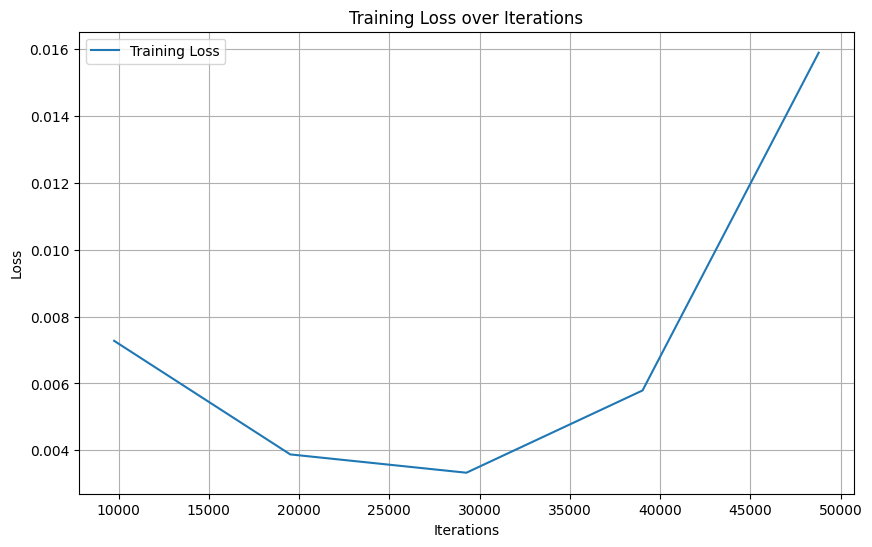

In [5]:
import matplotlib.pyplot as plt
import re

# Extract iteration numbers and losses
iterations = re.findall(r"iters: (\d+)", log_contents)
losses = re.findall(r"\| loss: ([0-9.]+)", log_contents)

# Convert the extracted strings to integers and floats respectively
iterations = [int(iter) for iter in iterations]
losses = [float(loss) for loss in losses]

# Extract final loss values
train_loss_match = re.search(r"Train Loss: ([0-9.]+)", log_contents)
vali_loss_match = re.search(r"Vali Loss: ([0-9.]+)", log_contents)
test_loss_match = re.search(r"Test Loss: ([0-9.]+)", log_contents)

if train_loss_match and vali_loss_match and test_loss_match:
    train_loss = float(train_loss_match.group(1))
    vali_loss = float(vali_loss_match.group(1))
    test_loss = float(test_loss_match.group(1))

    # Print final loss values
    print(f"Final Train Loss: {train_loss}")
    print(f"Final Validation Loss: {vali_loss}")
    print(f"Final Test Loss: {test_loss}")

    # Plot the training loss over iterations
    plt.figure(figsize=(10, 6))
    plt.plot(iterations, losses, label='Training Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Training Loss over Iterations')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Failed to extract final loss values from the log.")


Model Training and Evaluation Logs
       epoch  train_loss  vali_loss  test_loss  loss_pred  loss_entropy  \
Run 1      1    0.013662   0.003723   0.004789   0.007862      0.002831   
Run 2      1    0.016805   0.004826   0.005935   0.009989      0.003236   
Run 3      1    0.017467   0.006086   0.007449   0.013131      0.002266   
Run 4      1    0.025424   0.008856   0.009862   0.020503      0.002726   

       loss_smooth         time  
Run 1     0.002969  3615.073413  
Run 2     0.003580  3494.292993  
Run 3     0.002070  3898.435118  
Run 4     0.002195  4388.012968  


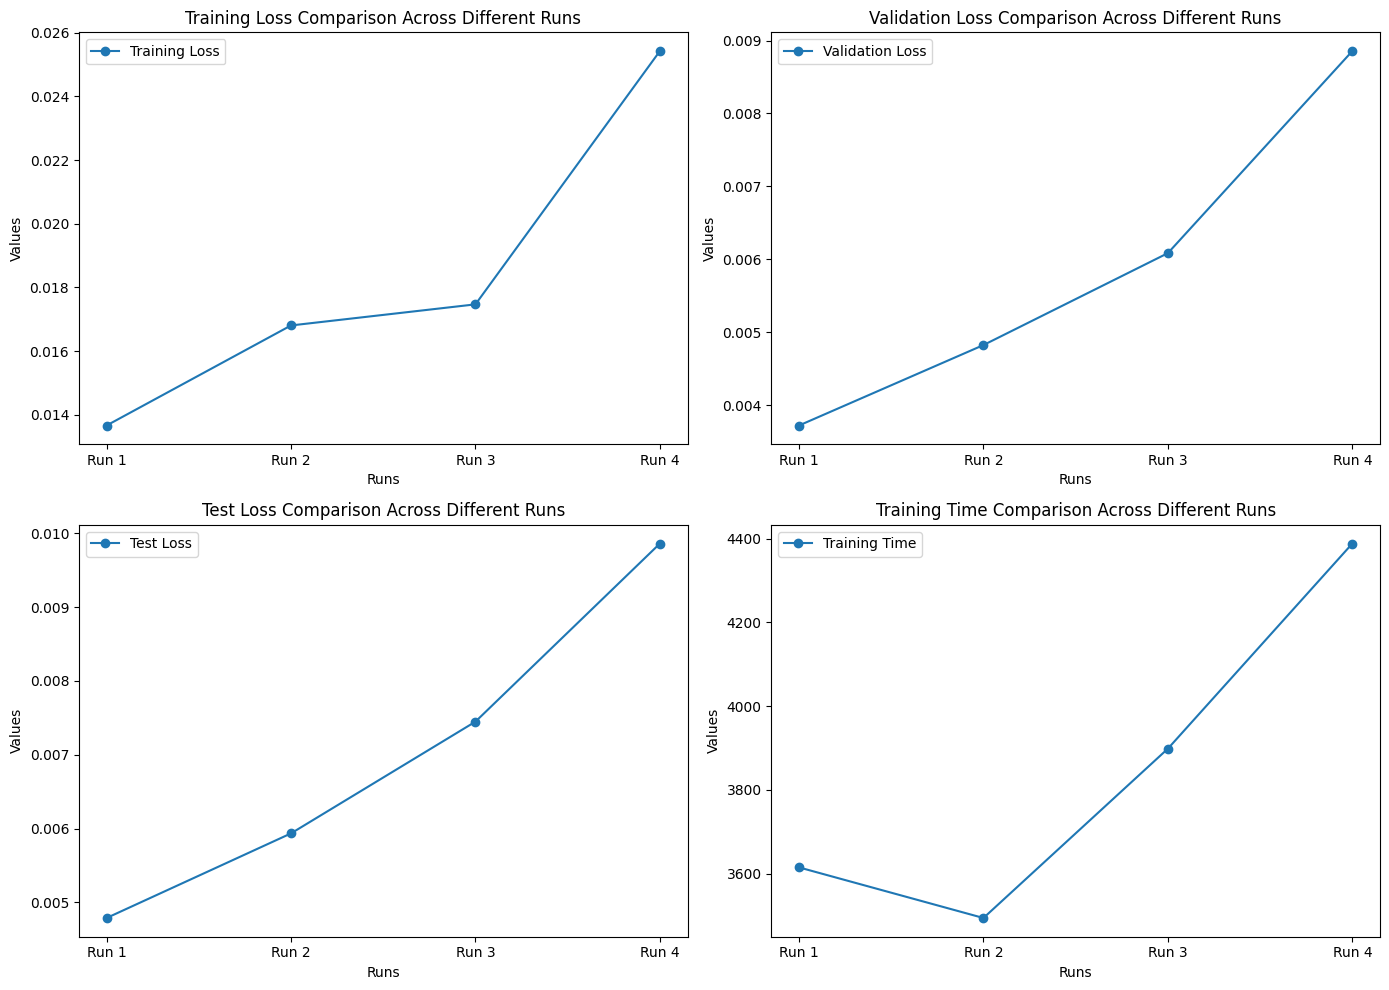

In [10]:
import pandas as pd
import matplotlib.pyplot as plt


# Log data from runs
log_data = [
    {
        "epoch": 1,
        "train_loss": 0.0136619,
        "vali_loss": 0.0037231,
        "test_loss": 0.0047886,
        "loss_pred": 0.00786220448397294,
        "loss_entropy": 0.0028309395584325187,
        "loss_smooth": 0.0029687882786803167,
        "time": 3615.073413133621
    },
    {
        "epoch": 1,
        "train_loss": 0.0168049,
        "vali_loss": 0.0048258,
        "test_loss": 0.0059350,
        "loss_pred": 0.009989046275941741,
        "loss_entropy": 0.0032360439873068076,
        "loss_smooth": 0.003579777969087008,
        "time": 3494.2929928302765
    },
    {
        "epoch": 1,
        "train_loss": 0.0174674,
        "vali_loss": 0.0060858,
        "test_loss": 0.0074490,
        "loss_pred": 0.013131296017147276,
        "loss_entropy": 0.002265935485545761,
        "loss_smooth": 0.0020701771458536506,
        "time": 3898.435118198395
    },
    {
        "epoch": 1,
        "train_loss": 0.0254245,
        "vali_loss": 0.0088556,
        "test_loss": 0.0098619,
        "loss_pred": 0.020502921171709872,
        "loss_entropy": 0.002726393998175982,
        "loss_smooth": 0.002195145425148305,
        "time": 4388.012967824936
    }
]

# Create a DataFrame
df = pd.DataFrame(log_data)
df.index = [f'Run {i+1}' for i in range(len(log_data))]

# Display the DataFrame
print("Model Training and Evaluation Logs")
print(df)

# Plotting
plt.figure(figsize=(14, 10))

# Training Loss
plt.subplot(2, 2, 1)
plt.plot(df.index, df['train_loss'], marker='o', label='Training Loss')
plt.xlabel('Runs')
plt.ylabel('Values')
plt.title('Training Loss Comparison Across Different Runs')
plt.legend()

# Validation Loss
plt.subplot(2, 2, 2)
plt.plot(df.index, df['vali_loss'], marker='o', label='Validation Loss')
plt.xlabel('Runs')
plt.ylabel('Values')
plt.title('Validation Loss Comparison Across Different Runs')
plt.legend()

# Test Loss
plt.subplot(2, 2, 3)
plt.plot(df.index, df['test_loss'], marker='o', label='Test Loss')
plt.xlabel('Runs')
plt.ylabel('Values')
plt.title('Test Loss Comparison Across Different Runs')
plt.legend()

# Training Time
plt.subplot(2, 2, 4)
plt.plot(df.index, df['time'], marker='o', label='Training Time')
plt.xlabel('Runs')
plt.ylabel('Values')
plt.title('Training Time Comparison Across Different Runs')
plt.legend()

plt.tight_layout()
plt.show()